# Project: Identifying Alternative Marker Genes for Strain-Level Differentiation in Vibrio splendidus

Author: Kiley Huffman

Lab: Schwartzman Lab

Date Initiated: 6/6/2025

In [21]:
# Required Packages: load at the start of each session
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from collections import Counter
import csv
from itertools import combinations
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# This file contains all of the function definitions needed to run the code in this file
# Functions are defined and explained in this file
import msa_functions
from msa_functions import process_alignment

# Multiple Sequence Alignment (MSA) Processing

The "main" function employs functions defined in msa_functions.py to analyze a collection of FASTA files, containing aligned gene sequences from 17 closely related V. splendidus strains. The gene alignments were generated by Eesha Rangani using the Anvi’o platform, which was used to identify orthologous gene clusters and export aligned sequences for each gene. Each FASTA file contains orthologous gene sequences from multiple Vibrio splendidus strains aligned by position.

Running the code below will results in the "alignment_stats.csv" being created, which contains the following columns of data:

'filename': The name of the aligned FASTA file being analyzed, e.g. "GC_00000990_aligned.fasta".

'alignment_length': The minimum sequence length among the sequences in the alignment.

'max_zeroes': The maximum number of zeroes in any consensus column in the alignment.

'mean_zeroes': The average number of zeroes per consensus matrix column (across the alignment).

'variance_zeroes': The variance of zero counts across the matrix.

'count_76_zero_blocks': The number of contiguous blocks of length 76 base pairs with all-zero consensus values.

'num_perfect_matches': The total number of perfectly conserved 20-mers (regions with no sequence variation across all strains).

'max_dist_between_matches': The longest distance (in bp) between any two conserved 20-mer regions.

'normalized_perfect_match_rate': This is a normalized count of perfect 20-mers, scaled by alignment length. 

'min_percent_identity': Lowest similarity between any two strains.

'max_percent_identity': Highest similarity between any two strains.

'avg_percent_identity': Mean similarity across all pairwise comparisons.

In [19]:
# Only run "main" if making changes to alignment_stats.csv...it takes a long time to run depending on how large your dataset is. 
def main():
    # Replace "aligned_files" with the path to the directory contain your aligned FASTA files
    aligned_path = "aligned_files"

    # Processes all alignments, block_size is the k-mer length
    results = process_alignment(aligned_path, block_size=20)

    # Can comment this chunk out if you do not want the print message
    for row in results:
        print(f"\nResults for {row['filename']}:")
        for key, value in row.items():
            if key != 'filename':
                print(f"  {key}: {value}")
    
    save_to_csv(results) # Saves results to alignment_stats.csv

# Run the main function
if __name__ == "__main__":
    main()

# Finding Marker Genes: gyrB, rpoB, hsp60, and ecA

These protein-coding genes have demonstrated greater variability than 16S rRNA in other bacterial groups, making them promising candidates for strain-level analysis in other taxa. This coding chunk locates these genes within our collection of aligned FASTA files. 

In [22]:
# Load the *summary.txt file as a df
df = pd.read_csv('V_splendidus_gene_clusters_summary.txt', sep='\t')

# Instantiate ist of target genes
target_genes = ['gyrB', 'rpoB', 'hsp60', 'ecA']

# Find the gene clusters for each target gene
for gene in target_genes:
    matches = df[
        df['COG20_FUNCTION'].str.contains(gene, case=False, na=False) |
        df['KOfam'].str.contains(gene, case=False, na=False)
    ]
    if not matches.empty:
        print(f"\nResults for {gene}:")
        print(matches[['gene_cluster_id', 'COG20_FUNCTION', 'KOfam']])
    else:
        print(f"\n{gene} not found in COG20_FUNCTION or KOfam columns.")

/var/folders/_g/_psh8dpd7bl2197ft_38stfh0000gn/T/ipykernel_59478/3180205803.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('V_splendidus_gene_clusters_summary.txt', sep='\t')



Results for gyrB:
      gene_cluster_id                                     COG20_FUNCTION  \
6972      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6973      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6974      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6975      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6976      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6977      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6978      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6979      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6980      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6981      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6982      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) ...   
6983      GC_00000267  DNA gyrase/topoisomerase IV, subunit B (GyrB) 

# Check which of the target GCs exist in the dataframe 
Only 3 were present explaining why on the plot above there are only 3 red gene clusters:

GC_00001281 --> GyrB

GC_00002298 --> hsp60

GC_00002774 --> rpoB

# Find pairwise identity for these genes:

In [31]:
# List of specific files containing the marker genes found in our data set
files = [
    "aligned_files/GC_00001281_aligned.fasta",
    "aligned_files/GC_00002774_aligned.fasta",
    "aligned_files/GC_00002298_aligned.fasta"
]

print("Order: gyrB, rpoB, hsp60")

for file in files:
    if os.path.exists(file):
        # Load sequences from the file
        sequences = [str(record.seq).upper() for record in SeqIO.parse(file, "fasta")]
        
        if len(sequences) >= 2:
            min_id, max_id, avg_id = calculate_pairwise_identity(sequences)
            print(f"{os.path.basename(file)}:")
            print(f"  Min Identity:  {min_id:.2f}%")
            print(f"  Max Identity:  {max_id:.2f}%")
            print(f"  Avg Identity:  {avg_id:.2f}%\n")
        else:
            print(f"{file}: Not enough sequences to calculate pairwise identity.\n")
    else:
        print(f"{file} not found.\n")


Order: gyrB, rpoB, hsp60
GC_00001281_aligned.fasta:
  Min Identity:  89.31%
  Max Identity:  100.00%
  Avg Identity:  96.58%

GC_00002774_aligned.fasta:
  Min Identity:  97.00%
  Max Identity:  100.00%
  Avg Identity:  99.19%

GC_00002298_aligned.fasta:
  Min Identity:  93.32%
  Max Identity:  100.00%
  Avg Identity:  97.27%



# Compare known marker genes (gyrB, rpoB, hsp60)

In [8]:
known_results = process_alignment("known_markers", block_size=20)
df_known = pd.DataFrame(known_results)

# Select key columns
df_known = df_known[['filename', 'avg_percent_identity', 'max_zeroes', 'normalized_perfect_match_rate']]

# Sort by avg_percent_identity (lower is better for strain resolution)
df_known = df_known.sort_values(by='avg_percent_identity')

print(df_known)

              filename  avg_percent_identity  max_zeroes  \
0   gyrB_aligned.fasta                 96.58          80   
1  hsp60_aligned.fasta                 97.27          80   
2   rpoB_aligned.fasta                 99.19          80   

   normalized_perfect_match_rate  
0                         0.0736  
1                         0.1093  
2                         0.4825  


gyrB appears to be the most suitable marker for differentiating Vibrio strains because:

-has the lowest average pairwise identity (96.58%), implying greater sequence variability.

-has the lowest normalized perfect match rate (0.0736), fewer perfectly conserved regions.

# Find variable regions between the conserved regions (perfect 20-mers)

In [66]:
collect_all_variable_regions()

Saved 1245 variable regions to all_variable_regions.csv


# Find GC Content of Upstream and Downstream Perfect 20mers

For each row in all_variable_regions.csv:
1) Use the filename column to load the corresponding aligned FASTA file (from aligned_files/)
2) Use start and end (alignment coordinates) to find the perfectly conserved 20-mer immediately upstream and downstream
3) Calculate GC content of those 20-mers
4) Output a new CSV with: filename, upstream_20mer, upstream_GC_content, downstream_20mer, downstream_GC_content

In [4]:
# Load the variable region CSV
df = pd.read_csv("all_variable_regions.csv")
results = []

for i, row in df.iterrows():
    filename = row['filename']  # e.g., GC_00002949_aligned.fasta
    var_start = int(row['start'])
    var_end = int(row['end'])

    fasta_path = os.path.join("aligned_files", filename)
    if not os.path.exists(fasta_path):
        print(f"Skipping missing file: {fasta_path}")
        continue

    records = list(SeqIO.parse(fasta_path, "fasta"))
    if not records:
        print(f"No sequences in {filename}")
        continue

    aligned_seqs = [str(r.seq).upper() for r in records]
    alignment_length = len(aligned_seqs[0])

    if var_start < 20 or var_end + 20 > alignment_length:
        print(f"Variable region too close to edge in {filename}")
        continue

    upstream_20mer = get_conserved_20mer(aligned_seqs, var_start, 'upstream')
    downstream_20mer = get_conserved_20mer(aligned_seqs, var_end, 'downstream')

    results.append({
        "filename": filename,
        "upstream_20mer": upstream_20mer,
        "upstream_GC_content": gc_content(upstream_20mer) if upstream_20mer else None,
        "downstream_20mer": downstream_20mer,
        "downstream_GC_content": gc_content(downstream_20mer) if downstream_20mer else None,
    })

# Save results
output_df = pd.DataFrame(results)
output_df.to_csv("conserved_flanks_gc_content.csv", index=False)
print("Saved to conserved_flanks_gc_content.csv")

Variable region too close to edge in GC_00001565_aligned.fasta
Variable region too close to edge in GC_00001739_aligned.fasta
Variable region too close to edge in GC_00001488_aligned.fasta
Variable region too close to edge in GC_00001422_aligned.fasta
Variable region too close to edge in GC_00002641_aligned.fasta
Variable region too close to edge in GC_00000709_aligned.fasta
Variable region too close to edge in GC_00002168_aligned.fasta
Variable region too close to edge in GC_00001700_aligned.fasta
Variable region too close to edge in GC_00001933_aligned.fasta
Variable region too close to edge in GC_00001999_aligned.fasta
Variable region too close to edge in GC_00002549_aligned.fasta
Variable region too close to edge in GC_00002645_aligned.fasta
Variable region too close to edge in GC_00001919_aligned.fasta
Variable region too close to edge in GC_00002259_aligned.fasta
Variable region too close to edge in GC_00001713_aligned.fasta
Variable region too close to edge in GC_00001321_aligne

In [8]:
# Load the GC content data
df = pd.read_csv("conserved_flanks_gc_content.csv")

# Filter for GC content between 25% and 75% in BOTH flanks
filtered = df[
    (df["upstream_GC_content"].between(25, 75, inclusive='both')) &
    (df["downstream_GC_content"].between(25, 75, inclusive='both'))
]

# Save the filtered dataframe
filtered.to_csv("conserved_flanks_both_25_75_gc.csv", index=False)
print(f"{len(filtered)} entries saved to conserved_flanks_both_25_75_gc.csv")


819 entries saved to conserved_flanks_both_25_75_gc.csv


# Find high-quality primers: filtering by GC Content (40-60%)

In [26]:
# Load data
df = pd.read_csv("conserved_flanks_gc_content.csv")

# Drop rows with missing 20-mers
df = df.dropna(subset=["upstream_20mer", "downstream_20mer"])

# Apply primer suitability filters
filtered = df[
    (df["upstream_GC_content"].between(40, 60)) &
    (df["downstream_GC_content"].between(40, 60)) &
    (df["upstream_20mer"].apply(gc_clamp)) &
    (df["downstream_20mer"].apply(gc_clamp))
].copy()

# Compute Tm for both 20-mers
filtered["upstream_Tm"] = filtered["upstream_20mer"].apply(wallace_tm)
filtered["downstream_Tm"] = filtered["downstream_20mer"].apply(wallace_tm)

# Compute closeness to 50% GC
filtered["upstream_GC_dist"] = filtered["upstream_GC_content"].apply(gc_diff_from_50)
filtered["downstream_GC_dist"] = filtered["downstream_GC_content"].apply(gc_diff_from_50)
filtered["total_GC_dist"] = filtered["upstream_GC_dist"] + filtered["downstream_GC_dist"]

# Rank by GC closeness (smaller = better)
filtered = filtered.sort_values("total_GC_dist")

# Save results
filtered.to_csv("primer_ready_ranked.csv", index=False)
print(f"{len(filtered)} high-quality primer candidates ranked and saved to primer_ready_ranked.csv")


281 high-quality primer candidates ranked and saved to primer_ready_ranked.csv


# Calculate consensus matrix score for variable regions, and filter primers by which ones are flanking the most variable sequences

In [35]:
# Load variable region info
regions = pd.read_csv("all_variable_regions.csv")
primer_df = pd.read_csv("primer_ready_ranked.csv")

variability_scores = []

for _, row in regions.iterrows():
    fname = row["filename"]
    start, end = int(row["start"]), int(row["end"])
    fpath = os.path.join("aligned_files", fname)

    if not os.path.exists(fpath):
        print(f"Skipping missing file: {fname}")
        continue

    records = list(SeqIO.parse(fpath, "fasta"))
    if not records:
        continue

    aligned_seqs = [str(r.seq).upper() for r in records]
    aln_length = len(aligned_seqs[0])

    if end > aln_length or start < 0 or start >= end:
        continue

    # Extract alignment columns for variable region
    submatrix = list(zip(*[seq[start:end] for seq in aligned_seqs]))

    entropies = [shannon_entropy(col) for col in submatrix]
    avg_entropy = sum(entropies) / len(entropies) if entropies else 0

    variability_scores.append({
        "filename": fname,
        "variability": avg_entropy
    })

# Merge variability scores with primer-ready regions
variability_df = pd.DataFrame(variability_scores)
merged = primer_df.merge(variability_df, on="filename", how="inner")

# Sort by variability score (most variable first)
merged_sorted = merged.sort_values("variability", ascending=False)

# Save
merged_sorted.to_csv("primer_ready_ranked_by_variability.csv", index=False)
print(f"{len(merged_sorted)} primer regions ranked by variability saved to primer_ready_ranked_by_variability.csv")

497 primer regions ranked by variability saved to primer_ready_ranked_by_variability.csv


# Filter primers to find the best candidate genes

In [3]:
# Load the ranked, annotated primer file
df = pd.read_csv("primer_ready_ranked_by_variability.csv")

# Drop incomplete primer pairs
df = df.dropna(subset=["upstream_20mer", "downstream_20mer", "variability"])

# 1. GC content: Keep 40–60% (or 25–75% if being lenient)
gc_ok = (
    df["upstream_GC_content"].between(40, 60) &
    df["downstream_GC_content"].between(40, 60)
)

# 2. Tm: Keep 55–65°C
tm_ok = (
    df["upstream_Tm"].between(55, 65) &
    df["downstream_Tm"].between(55, 65)
)

# 3. High variability: Top 20% of all entropy scores
threshold = df["variability"].quantile(0.80)  # top 20%
high_var = df["variability"] >= threshold

# 4. Combine filters
filtered = df[gc_ok & tm_ok & high_var]

# 5. Optional: Sort by variability
filtered = filtered.sort_values("variability", ascending=False)

# Save
filtered.to_csv("best_strain_differentiation_primers.csv", index=False)
print(f"{len(filtered)} primer pairs saved to best_strain_differentiation_primers.csv")


100 primer pairs saved to best_strain_differentiation_primers.csv


# Best Primer Identification

1. 47373 GC_00002632	SCG	V_splendidus_F2R02	2118	17	17	1	1	0.975020208235308	0.946466715969292	0.960531308194221	U	Intracellular trafficking, secretion, and vesicular transport	COG0552	Signal recognition particle GTPase FtsY (FtsY) (PDB:4AK9)	K03110	fused signal recognition particle receptor

2. 40522	GC_00002229	SCG	V_splendidus_F2R02	666	17	17	1	1	0.996698841698842	0.973177820746619	0.984797906586716	E	Amino acid transport and metabolism	COG0626	Methionine biosynthesis	COG0626	Cystathionine beta-lyase/cystathionine gamma-synthase (MetC) (PDB:1CL1)		



In [30]:
# Extract annotations from GC_00002632_aligned.fasta and GC_00002229_aligned.fasta for phylogeny building
ann1 = extract_annotations("aligned_files/GC_00002632_aligned.fasta")
ann2 = extract_annotations("aligned_files/GC_00002229_aligned.fasta")

annotations = pd.concat([ann1, ann2])
annotations.to_csv("annotations_for_tree.csv", index=False)

In [38]:
# Find variable regions for these two files
from Bio import SeqIO
import pandas as pd

# Load the CSV
df = pd.read_csv("all_variable_regions.csv")

# Filter for the two files of interest
targets = ["GC_00002632_aligned.fasta", "GC_00002229_aligned.fasta"]
filtered = df[df["filename"].isin(targets)]

print(filtered)


                      filename  start   end  length
144  GC_00002229_aligned.fasta      0   365     366
145  GC_00002229_aligned.fasta    716  1052     337
162  GC_00002632_aligned.fasta      0   305     306
163  GC_00002632_aligned.fasta    626   953     328
164  GC_00002632_aligned.fasta   1050  1295     246


# Finding Variable Region Indexes, Trim Sequences to Variable Region, and Generate New FASTA for the Candidate Genes

In [43]:
# Inputs
fasta_file = "aligned_files/GC_00002632_aligned.fasta"
upstream_20mer = "CTGCTCAAAGAAGAGATGGC"
downstream_20mer = "GGTCGTTTGCAGAACAAGAG"
output_file = "GC_00002632_trimmed_amplicon.fasta"

# Load aligned sequences
records = list(SeqIO.parse(fasta_file, "fasta"))
aligned_seqs = [str(rec.seq).upper() for rec in records]

# Use first sequence to find primer locations
ref_seq = aligned_seqs[0]
start = ref_seq.find(upstream_20mer)
end = ref_seq.find(downstream_20mer)

if start == -1 or end == -1:
    raise ValueError("One or both primers not found in the alignment.")

end += len(downstream_20mer)  # inclusive end

# Trim sequences
trimmed_records = []
for i, rec in enumerate(records):
    trimmed_seq = rec.seq[start:end]
    trimmed_record = SeqRecord(trimmed_seq, id=rec.id, description="")
    trimmed_records.append(trimmed_record)

# Write to new FASTA
SeqIO.write(trimmed_records, output_file, "fasta")
print(f"Trimmed region ({start}-{end}) saved to {output_file}")


Trimmed region (606-974) saved to GC_00002632_trimmed_amplicon.fasta


In [47]:
# Inputs
fasta_file = "aligned_files/GC_00002229_aligned.fasta"
upstream_20mer = "ACCGGCACACCATTTGATAG"
downstream_20mer = "GCAGAAGCGGGTGTTTCTCA"
output_file = "GC_00002229_trimmed_amplicon.fasta"

# Load sequences
records = list(SeqIO.parse(fasta_file, "fasta"))
aligned_seq = str(records[0].seq).upper()  # Reference
ungapped_seq = aligned_seq.replace("-", "")

# Map ungapped positions to aligned indices
ungapped_to_aligned = []
ungapped_index = 0
for i, char in enumerate(aligned_seq):
    if char != "-":
        if len(ungapped_to_aligned) <= ungapped_index:
            ungapped_to_aligned.append(i)
        ungapped_index += 1

# Find primers in ungapped sequence
up_idx = ungapped_seq.find(upstream_20mer)
down_idx = ungapped_seq.find(downstream_20mer)

if up_idx == -1 or down_idx == -1:
    raise ValueError("One or both primers not found in ungapped version of alignment.")

# Convert to aligned positions
start_aligned = ungapped_to_aligned[up_idx]
end_aligned = ungapped_to_aligned[down_idx + len(downstream_20mer) - 1]

# Extract region from all aligned sequences
trimmed_records = []
for rec in records:
    trimmed_seq = rec.seq[start_aligned:end_aligned + 1]  # inclusive
    trimmed_records.append(SeqRecord(trimmed_seq, id=rec.id, description=""))

# Save trimmed alignment
SeqIO.write(trimmed_records, output_file, "fasta")
print(f"Trimmed region ({start_aligned}-{end_aligned}) saved to {output_file}")


Trimmed region (696-1072) saved to GC_00002229_trimmed_amplicon.fasta


# Find the distance between kmers for the best primer candidates 

In [10]:
import pandas as pd

# Load the two CSVs
var_df = pd.read_csv("csvs/all_variable_regions.csv")
primers_df = pd.read_csv("csvs/best_strain_differentiation_primers.csv")

# Filter: keep only rows in var_df where filename is in primers_df
filtered_df = var_df[var_df["filename"].isin(primers_df["filename"])]

# Save result
filtered_df.to_csv("filtered_variable_regions.csv", index=False)

print(f"Filtered {len(filtered_df)} regions saved to 'filtered_variable_regions.csv'")


Filtered 137 regions saved to 'filtered_variable_regions.csv'


# Generate a comparison of the 17 genomes (all by all comparison) using fastANI

In [7]:
# Load FastANI output
df = pd.read_csv("fastani_output.txt", sep="\t", header=None)
df.columns = ["query", "reference", "ani", "fragments_aligned", "total_fragments"]

# Extract base names for matrix index
df["query"] = df["query"].apply(lambda x: x.split("/")[-1].replace(".fna", ""))
df["reference"] = df["reference"].apply(lambda x: x.split("/")[-1].replace(".fna", ""))

# Pivot to matrix
ani_matrix = df.pivot(index="query", columns="reference", values="ani")

# Fill diagonal
for genome in ani_matrix.index:
    ani_matrix.loc[genome, genome] = 100.0

# Fill missing with 0 or NaN
ani_matrix = ani_matrix.fillna(0)


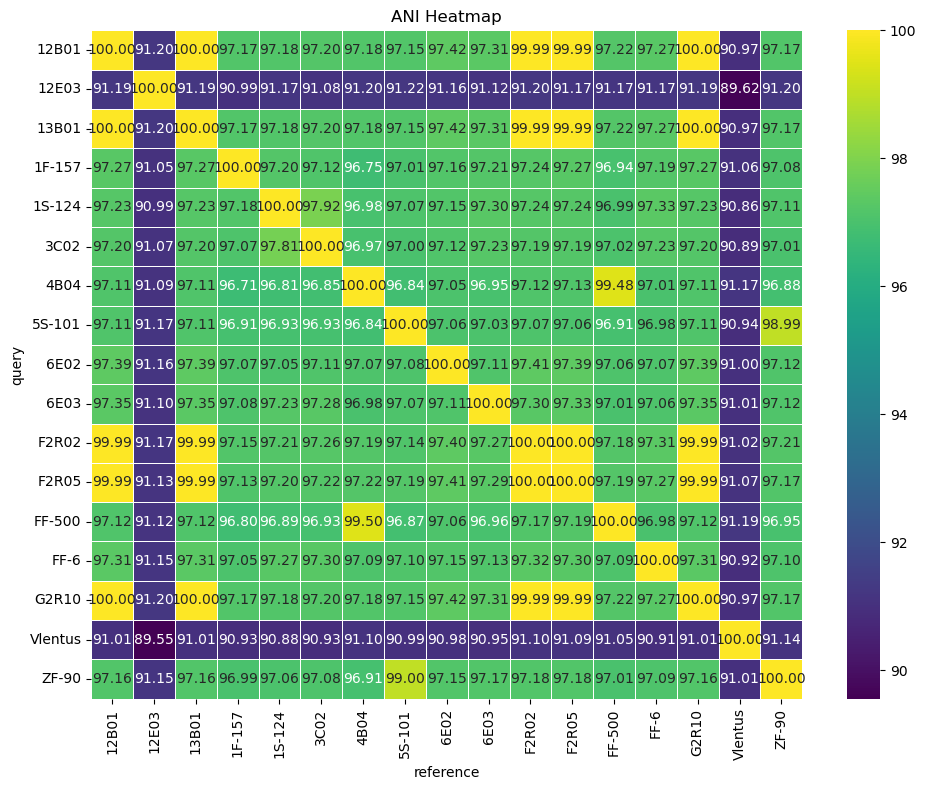

In [9]:
#Plot heat map
plt.figure(figsize=(10, 8))
sns.heatmap(ani_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)
plt.title("ANI Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("figures/ani_heatmap.png", dpi=300)
plt.show()

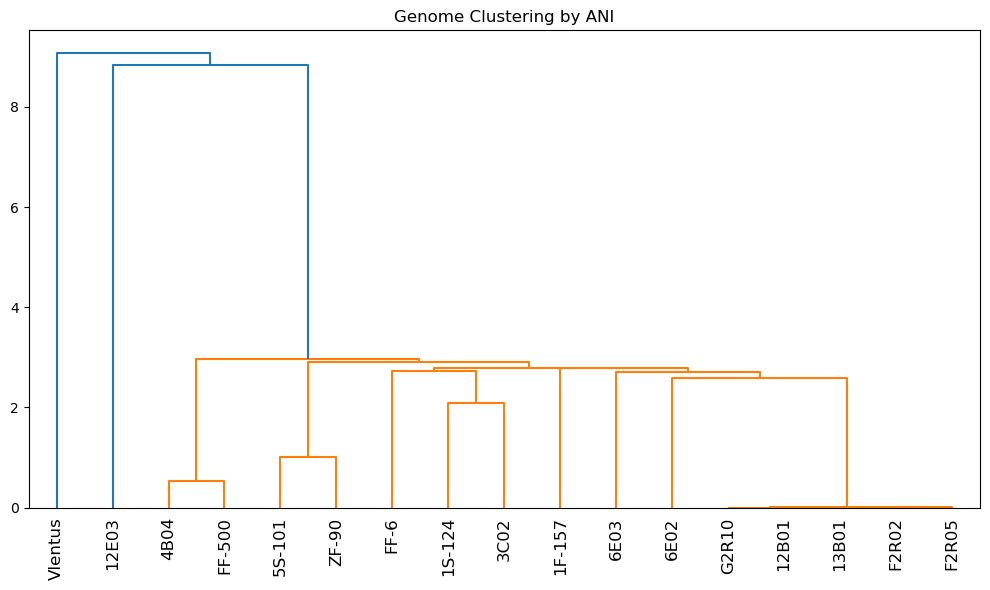

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Convert to distance matrix (100 - ANI)
import numpy as np
from scipy.spatial.distance import squareform

ani_dist = 100 - ani_matrix
condensed = squareform(ani_dist.values, checks=False)
linkage_matrix = linkage(condensed, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=ani_matrix.index.tolist(), leaf_rotation=90)
plt.title("Genome Clustering by ANI")
plt.tight_layout()
plt.savefig("figures/ani_dendrogram.png", dpi=300)
plt.show()
